# Signal to Binary Files Train&Test

In [474]:
#!pip install ibmseti

In [1]:
import requests
import json
import ibmseti
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

### Get file list

I have a list of simulated files stored in an OpenStack Object Storage container that is world-readable.

Download that file, split by lines and parallelize it into an RDD

In [2]:
# The code was removed by DSX for sharing.

In [3]:
filelist_txt = r.text

In [4]:
fl_rdd = sc.parallelize(filelist_txt.split('\n')[:-1], 20)

In [5]:
fl_rdd.count()

1000

#### Quick Inspection.

Take a look at the first row. Each line is JSON with a 'file_name', 'uuid' and 'signal_classification'. 

Then I show you the different "signal_classifications" we have. 

In [6]:
fl_rdd.first()

u'{"file_name": "00cb8c44-2289-445b-be14-14dfd7c6b2da.dat", "signal_classification": "narrowbanddrd", "uuid": "00cb8c44-2289-445b-be14-14dfd7c6b2da"}'

In [7]:
fl_rdd2 = fl_rdd.map(lambda row: json.loads(row))

In [8]:
fl_rdd2.cache()

PythonRDD[3] at RDD at PythonRDD.scala:43

In [9]:
# The code was removed by DSX for sharing.

In [10]:
rdd_fname_lb = fl_rdd2.map(lambda row: (row['signal_classification'],row['file_name']))

In [11]:
classes = rdd_fname_lb.map(lambda row: row[0]).distinct().collect()
dictClass = dict(zip(classes, np.arange(4)))
dictClass

{u'narrowband': 2, u'narrowbanddrd': 1, u'noise': 3, u'squiggle': 0}

In [12]:
rdd_req = rdd_fname_lb.map(lambda row: (row[1], dictClass[row[0]], requests.get('{}/{}/{}'.format(base_url, container, row[1]))))
rdd_req.take(3)

[(u'00cb8c44-2289-445b-be14-14dfd7c6b2da.dat', 1, <Response [200]>),
 (u'00e71671-048b-46cc-a260-2a709953f3f8.dat', 0, <Response [200]>),
 (u'012b16c9-7c54-4e8f-a210-8c2ce39760b9.dat', 0, <Response [200]>)]

In [13]:
rdd_req.cache()

PythonRDD[10] at RDD at PythonRDD.scala:43

In [14]:
rdd_aca = rdd_req.map(lambda r: (r[0], r[1], ibmseti.compamp.SimCompamp(r[2].content)))

### Spectrogram small size

In [169]:
h = 256
w = 512

In [170]:
def spect(aca,h,w):
    com_data = aca.complex_data()
    data_redux = com_data[:h*w]
    reshaped_data = data_redux.reshape(h,w)
    spec = np.abs( np.fft.fftshift( np.fft.fft(reshaped_data), 1) )**2
    spec_data = spec.reshape(h*w,)
    return spec_data
    

In [171]:
def draw_spectrogram(fname):
    r = requests.get('{}/{}/{}'.format(base_url, container, fname), timeout=4.0)
    if r.status_code != 200:
        print 'Failed retrieving {}'.format(fname)
        print r
        return None
    else:
        aca = ibmseti.compamp.SimCompamp(r.content)
#         print aca.header()
        spec = aca.get_spectrogram()
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0])
        return fig

In [172]:
rdd_spec = rdd_aca.map(lambda lb_aca:(lb_aca[0], lb_aca[1], spect(lb_aca[2],h,w))) 

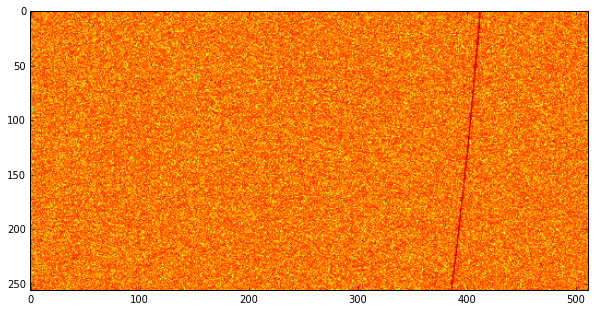

In [173]:
y= rdd_spec.take(1)[0][2]
img_data= y.reshape(h,w)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(img_data))

### Convert spec to grayscale

L


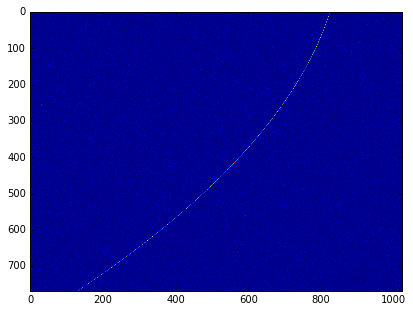

In [138]:
from PIL import Image
def grayimagedata(img_data):
    #img_data= np.log(imagedata)
    img = Image.fromarray(np.uint8(img_data/np.max(img_data)*255))
    #img = Image.fromarray(img_data/np.max(img_data))
    #img = img.convert('I')
    img_data = np.asarray(img)
    return img_data
    
gray_y = grayimagedata(y.reshape(h,w))
img_data = gray_y.reshape(h,w)
img = Image.fromarray(np.uint8(gray_y))
print (img.mode)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(img)

In [139]:
gray_y

array([[ 0,  7,  1, ...,  3,  4,  4],
       [ 0,  4, 10, ...,  6,  3,  2],
       [ 6,  1,  7, ...,  4,  2,  0],
       ..., 
       [ 1,  2,  0, ..., 20,  6,  0],
       [ 3, 13,  3, ...,  2,  6,  3],
       [ 3,  1, 11, ...,  0,  3,  7]], dtype=uint8)

In [140]:
rdd_gray_spec = rdd_spec.map(lambda lb_aca:(lb_aca[0], lb_aca[1], grayimagedata(lb_aca[2].reshape(h,w))))

In [141]:
rdd_gray_spec.take(1)

[(u'00cb8c44-2289-445b-be14-14dfd7c6b2da.dat',
  1,
  array([[ 0,  7,  1, ...,  3,  4,  4],
         [ 0,  4, 10, ...,  6,  3,  2],
         [ 6,  1,  7, ...,  4,  2,  0],
         ..., 
         [ 1,  2,  0, ..., 20,  6,  0],
         [ 3, 13,  3, ...,  2,  6,  3],
         [ 3,  1, 11, ...,  0,  3,  7]], dtype=uint8))]

# Train/Test

In [142]:
test, train = rdd_gray_spec.randomSplit(weights=[0.3, 0.7], seed=1)

In [143]:
train_data = train.map(lambda row: row[2]).collect()
train_img_data = np.array(train_data)
train_lbl = train.map(lambda row: row[1]).collect()

### Write to Binary file, mnist format

In [144]:
!rm SETI/SETI_ds_768x1024/*
!ls SETI/SETI_ds_768x1024/

rm: cannot remove ‘SETI/SETI_ds_768x1024/*’: No such file or directory
ls: cannot access SETI/SETI_ds_768x1024/: No such file or directory


In [145]:
from array import *
def wrtieToBinary(dsDirectory, name , imgData , lblData,h,w):
    
    n = imgData.shape[0]
    imgData = imgData.reshape(-1,)
    
    data_image = array('B')
    data_label = array('B')
    
    data_image.extend(imgData)

    # number of files in HEX
    hexval = "{0:#0{1}x}".format(n,6) 
    
    # header for label array
    data_label.extend(lblData)
    header = array('B')
    header.extend([0,0,8,1,0,0])
    header.append(int('0x'+hexval[2:][:2],16))
    header.append(int('0x'+hexval[2:][2:],16))
    data_label = header + data_label
    print ('Label header:' )
    print(header)
    # additional header for images array
    if max([w,h]) <= 255:
        header.extend([0,0,0,h,0,0,0,w])
    else:
        hex_h = "{0:#0{1}x}".format(h,6)
        header.extend([0,0])
        header.append(int('0x'+hex_h[2:][:2],16))
        header.append(int('0x'+hex_h[2:][2:],16))
        hex_w = "{0:#0{1}x}".format(w,6)
        header.extend([0,0])
        header.append(int('0x'+hex_w[2:][:2],16))
        header.append(int('0x'+hex_w[2:][2:],16))
        #raise ValueError('Image exceeds maximum size: 256x256 pixels');
    header[3] = 3 # Changing MSB for image data (0x00000803)
        
    if not os.path.exists(dsDirectory):
        os.makedirs(dsDirectory)
            
        
    print ('Image header:' )
    print(header)
    data_image = header + data_image

    output_file = open(dsDirectory + name+'-images-idx3-ubyte', 'wb')
    data_image.tofile(output_file)
    output_file.close()

    output_file = open(dsDirectory+ name+'-labels-idx1-ubyte', 'wb')
    data_label.tofile(output_file)
    output_file.close()
    
    # gzip resulting files


    os.system('gzip '+ dsDirectory + name +'-images-idx3-ubyte '+ name +'-images-idx3-ubyte.gz')
    os.system('gzip '+ dsDirectory + name +'-labels-idx1-ubyte ')


In [146]:
import os

dsDirectory = 'SETI/SETI_ds_768x1024/'


In [147]:
wrtieToBinary(dsDirectory, 'train' , train_img_data , train_lbl, h, w)

Label header:
array('B', [0, 0, 8, 1, 0, 0, 2, 182])
Image header:
array('B', [0, 0, 8, 3, 0, 0, 2, 182, 0, 0, 3, 0, 0, 0, 4, 0])


In [148]:
test_data = test.map(lambda row: row[2]).collect()
test_img_data = np.array(test_data)
test_lbl = test.map(lambda row: row[1]).collect()

In [149]:
wrtieToBinary(dsDirectory, 'test' , test_img_data , test_lbl, h, w)

Label header:
array('B', [0, 0, 8, 1, 0, 0, 1, 50])
Image header:
array('B', [0, 0, 8, 3, 0, 0, 1, 50, 0, 0, 3, 0, 0, 0, 4, 0])


### Verify it 

In [150]:
!ls SETI/SETI_ds_768x1024/

test-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
test-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [151]:
import numpy as np
import gzip
def _read32(bytestream):
  dt = np.dtype(np.uint32).newbyteorder('>')
  return np.frombuffer(bytestream.read(4), dtype=dt)[0]

with open(dsDirectory+'train-images-idx3-ubyte.gz', 'rb') as f:
    with gzip.GzipFile(fileobj=f ) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %(magic, f.name))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        print(magic,num_images,rows,cols,)
        
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols, 1)
# magic, num, rows, cols = struct.unpack(">IIII", bytestream.read(16))


(2051, 694, 768, 1024)


F


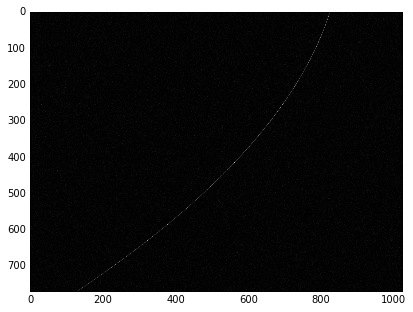

In [152]:
gray_y = data[0].reshape(768,1024)
img = Image.fromarray(np.float32(gray_y))
print (img.mode)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(img)

In [153]:
gray_y

array([[ 0,  7,  1, ...,  3,  4,  4],
       [ 0,  4, 10, ...,  6,  3,  2],
       [ 6,  1,  7, ...,  4,  2,  0],
       ..., 
       [ 1,  2,  0, ..., 20,  6,  0],
       [ 3, 13,  3, ...,  2,  6,  3],
       [ 3,  1, 11, ...,  0,  3,  7]], dtype=uint8)

### Verify by reader

In [154]:
!wget -q --output-document SETI.zip  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
!unzip -o SETI.zip
import SETI

Archive:  SETI.zip
  inflating: SETI.py                 
  inflating: __MACOSX/._SETI.py      


In [155]:
SETIds = SETI.read_data_sets(dsDirectory, one_hot=True, validation_size=0)
SETIds.train.num_examples

Extracting SETI/SETI_ds_768x1024/train-images-idx3-ubyte.gz
Extracting SETI/SETI_ds_768x1024/train-labels-idx1-ubyte.gz
Extracting SETI/SETI_ds_768x1024/test-images-idx3-ubyte.gz
Extracting SETI/SETI_ds_768x1024/test-labels-idx1-ubyte.gz


694

F


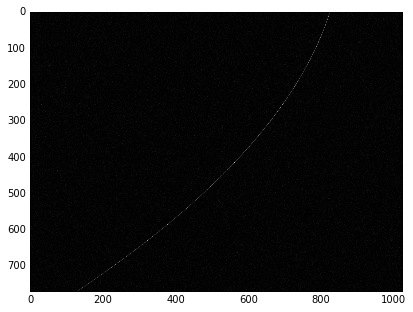

In [156]:
gray_y = SETIds.train.images[0].reshape(768,1024)
img = Image.fromarray(gray_y*255)
print (img.mode)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(img)

In [77]:
#test_y = mnist.train.images[0]
#test_y

# Export files to object storage

In [157]:
!ls -l --block-size=MB SETI/SETI_ds_768x1024/


total 1370MB
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users 142MB May 21 11:31 test-images-idx3-ubyte.gz
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users   1MB May 21 11:31 test-labels-idx1-ubyte.gz
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users 316MB May 21 11:29 train-images-idx3-ubyte.gz
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users   1MB May 21 11:29 train-labels-idx1-ubyte.gz


In [158]:
# The code was removed by DSX for sharing.

In [159]:
#!pip install --user --upgrade python-swiftclient

import swiftclient.client as swiftclient

conn = swiftclient.Connection(
    key=credentials_1['password'],
    authurl=credentials_1['auth_url']+"/v3",
    auth_version='3',
    os_options={
        "project_id": credentials_1['project_id'],
        "user_id": credentials_1['user_id'],
        "region_name": credentials_1['region']})

In [160]:
credentials_1['container']

'SETI2'

In [161]:
dsDirectory

'SETI/SETI_ds_768x1024/'

In [162]:
!ls SETI/SETI_ds_768x1024/

test-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
test-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


### Export as a single file

In [163]:
import gzip
local_file = 'SETI768x1024.tar.gz'
os.system('tar -zcvf '+local_file+' SETI/SETI_ds_768x1024')
print ('Moving '+ local_file + '...')
with open(local_file, 'rb') as f:
    with gzip.GzipFile(fileobj=f) as bytestream:
        etag = conn.put_object(credentials_1['container'], local_file , f.read() )

Moving SETI768x1024.tar.gz...


### Export as multiple files

In [ ]:
files = ['train-images-idx3-ubyte.gz','train-labels-idx1-ubyte.gz','test-images-idx3-ubyte.gz','test-labels-idx1-ubyte.gz']
for local_file in files:
    print ('Moving '+ local_file + '...')
    with open(dsDirectory + local_file, 'rb') as f:
        with gzip.GzipFile(fileobj=f) as bytestream:
            etag = conn.put_object(credentials_1['container'], local_file , f.read() )